# Method 5 - Rest Ideas After 1

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 1].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

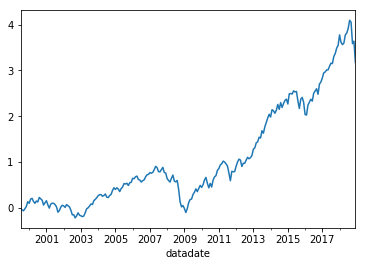

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.132463
2000-12-31   -0.020722
2001-12-31   -0.049558
2002-12-31   -0.204725
2003-12-31    0.454427
2004-12-31    0.178470
2005-12-31    0.083031
2006-12-31    0.110782
2007-12-31    0.017173
2008-12-31   -0.403684
2009-12-31    0.420224
2010-12-31    0.221650
2011-12-31   -0.015678
2012-12-31    0.195328
2013-12-31    0.421520
2014-12-31    0.108906
2015-12-31   -0.020727
2016-12-31    0.134186
2017-12-31    0.213999
2018-12-31   -0.083031
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2831.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.20e-193
Time:                        05:37:01   Log-Likelihood:                 837.08
No. Observations:                 234   AIC:                            -1664.
Df Residuals:                     229   BIC:                            -1647.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.697      0.000       0.001       0.003
mktrf          1.0071      0.013     78.977      0.000       0.982       1.032
me             0.2764      0.015     18.634      0.000       0.247       0.306
ia             0.0520      0.023      2.305      0.022       0.008       0.096
roe           -0.0289      0.019     -1.497      0.136      -0.067       0.009
==============================================================================
Omnibus:                       26.366   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.570
Skew:                          -0.170   Prob(JB):                     1.47e-27
Kurtosis:                       6.544   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1789.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.06e-171
Time:                        05:37:01   Log-Likelihood:                 837.08
No. Observations:                 234   AIC:                            -1664.
Df Residuals:                     229   BIC:                            -1647.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.814      0.000       0.001       0.003
mktrf          1.0071      0.016     63.062      0.000       0.976       1.038
me             0.2764      0.024     11.487      0.000       0.229       0.324
ia             0.0520      0.046      1.131      0.258      -0.038       0.142
roe           -0.0289      0.026     -1.102      0.271      -0.080       0.023
==============================================================================
Omnibus:                       26.366   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.570
Skew:                          -0.170   Prob(JB):                     1.47e-27
Kurtosis:                       6.544   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2313.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.97e-184
Time:                        05:37:01   Log-Likelihood:                 837.08
No. Observations:                 234   AIC:                            -1664.
Df Residuals:                     229   BIC:                            -1647.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      5.185      0.000       0.001       0.003
mktrf          1.0071      0.015     65.173      0.000       0.977       1.037
me             0.2764      0.023     12.062      0.000       0.231       0.321
ia             0.0520      0.048      1.079      0.280      -0.042       0.146
roe           -0.0289      0.029     -0.991      0.322      -0.086       0.028
==============================================================================
Omnibus:                       26.366   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.570
Skew:                          -0.170   Prob(JB):                     1.47e-27
Kurtosis:                       6.544   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1898.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.53e-183
Time:                        05:37:01   Log-Likelihood:                 817.34
No. Observations:                 234   AIC:                            -1623.
Df Residuals:                     228   BIC:                            -1602.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.762      0.000       0.001       0.003
mktrf          1.0197      0.014     73.193      0.000       0.992       1.047
smb            0.3027      0.018     16.465      0.000       0.266       0.339
hml            0.0166      0.022      0.766      0.445      -0.026       0.059
rmw           -0.0080      0.025     -0.327      0.744      -0.056       0.040
cma            0.0470      0.031      1.510      0.132      -0.014       0.108
==============================================================================
Omnibus:                       25.873   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.657
Skew:                          -0.031   Prob(JB):                     7.01e-29
Kurtosis:                       6.646   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1495.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.91e-172
Time:                        05:37:01   Log-Likelihood:                 817.34
No. Observations:                 234   AIC:                            -1623.
Df Residuals:                     228   BIC:                            -1602.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.513      0.000       0.001       0.003
mktrf          1.0197      0.019     54.767      0.000       0.983       1.056
smb            0.3027      0.024     12.607      0.000       0.256       0.350
hml            0.0166      0.048      0.343      0.732      -0.078       0.112
rmw           -0.0080      0.028     -0.283      0.777      -0.063       0.047
cma            0.0470      0.052      0.901      0.367      -0.055       0.149
==============================================================================
Omnibus:                       25.873   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.657
Skew:                          -0.031   Prob(JB):                     7.01e-29
Kurtosis:                       6.646   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2134.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.11e-189
Time:                        05:37:01   Log-Likelihood:                 817.34
No. Observations:                 234   AIC:                            -1623.
Df Residuals:                     228   BIC:                            -1602.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.491      0.000       0.001       0.003
mktrf          1.0197      0.018     56.409      0.000       0.984       1.055
smb            0.3027      0.024     12.389      0.000       0.255       0.351
hml            0.0166      0.051      0.324      0.746      -0.084       0.117
rmw           -0.0080      0.030     -0.263      0.792      -0.068       0.052
cma            0.0470      0.051      0.915      0.360      -0.054       0.148
==============================================================================
Omnibus:                       25.873   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.657
Skew:                          -0.031   Prob(JB):                     7.01e-29
Kurtosis:                       6.646   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2131.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.57e-180
Time:                        05:37:01   Log-Likelihood:                 804.60
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      4.016      0.000       0.001       0.003
mktrf          1.0154      0.013     75.282      0.000       0.989       1.042
smb            0.2890      0.017     17.164      0.000       0.256       0.322
hml            0.0898      0.017      5.367      0.000       0.057       0.123
umd           -0.0058      0.011     -0.529      0.597      -0.027       0.016
==============================================================================
Omnibus:                       27.406   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.416
Skew:                           0.014   Prob(JB):                     5.91e-33
Kurtosis:                       6.901   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1916.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.05e-174
Time:                        05:37:01   Log-Likelihood:                 804.60
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.356      0.001       0.001       0.003
mktrf          1.0154      0.019     54.408      0.000       0.979       1.052
smb            0.2890      0.025     11.541      0.000       0.240       0.338
hml            0.0898      0.049      1.842      0.065      -0.006       0.185
umd           -0.0058      0.020     -0.289      0.773      -0.045       0.034
==============================================================================
Omnibus:                       27.406   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.416
Skew:                           0.014   Prob(JB):                     5.91e-33
Kurtosis:                       6.901   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2605.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.35e-189
Time:                        05:37:01   Log-Likelihood:                 804.60
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.328      0.001       0.001       0.003
mktrf          1.0154      0.016     63.698      0.000       0.984       1.047
smb            0.2890      0.027     10.884      0.000       0.237       0.341
hml            0.0898      0.054      1.660      0.097      -0.016       0.196
umd           -0.0058      0.016     -0.363      0.717      -0.037       0.026
==============================================================================
Omnibus:                       27.406   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.416
Skew:                           0.014   Prob(JB):                     5.91e-33
Kurtosis:                       6.901   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1252.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.79e-94
Time:                        05:37:01   Log-Likelihood:                 409.88
No. Observations:                 120   AIC:                            -809.8
Df Residuals:                     115   BIC:                            -795.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.509      0.001       0.001       0.004
mktrf          1.0170      0.021     48.585      0.000       0.976       1.058
me             0.2594      0.021     12.549      0.000       0.218       0.300
ia             0.0897      0.032      2.772      0.007       0.026       0.154
roe           -0.0202      0.029     -0.704      0.483      -0.077       0.037
==============================================================================
Omnibus:                       10.301   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.683
Skew:                          -0.117   Prob(JB):                     4.37e-06
Kurtosis:                       5.209   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     993.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.89e-88
Time:                        05:37:01   Log-Likelihood:                 409.88
No. Observations:                 120   AIC:                            -809.8
Df Residuals:                     115   BIC:                            -795.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.587      0.000       0.001       0.004
mktrf          1.0170      0.027     37.285      0.000       0.964       1.070
me             0.2594      0.025     10.480      0.000       0.211       0.308
ia             0.0897      0.050      1.791      0.073      -0.008       0.188
roe           -0.0202      0.032     -0.641      0.522      -0.082       0.042
==============================================================================
Omnibus:                       10.301   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.683
Skew:                          -0.117   Prob(JB):                     4.37e-06
Kurtosis:                       5.209   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1625.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.76e-100
Time:                        05:37:01   Log-Likelihood:                 409.88
No. Observations:                 120   AIC:                            -809.8
Df Residuals:                     115   BIC:                            -795.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.745      0.000       0.001       0.004
mktrf          1.0170      0.023     43.344      0.000       0.971       1.063
me             0.2594      0.024     10.861      0.000       0.213       0.306
ia             0.0897      0.046      1.949      0.051      -0.001       0.180
roe           -0.0202      0.032     -0.626      0.531      -0.083       0.043
==============================================================================
Omnibus:                       10.301   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.683
Skew:                          -0.117   Prob(JB):                     4.37e-06
Kurtosis:                       5.209   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     806.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.60e-87
Time:                        05:37:01   Log-Likelihood:                 397.67
No. Observations:                 120   AIC:                            -783.3
Df Residuals:                     114   BIC:                            -766.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.364      0.001       0.001       0.005
mktrf          1.0567      0.025     43.053      0.000       1.008       1.105
smb            0.3000      0.028     10.793      0.000       0.245       0.355
hml           -0.0072      0.034     -0.212      0.833      -0.075       0.060
rmw            0.0269      0.040      0.669      0.505      -0.053       0.106
cma            0.1115      0.044      2.533      0.013       0.024       0.199
==============================================================================
Omnibus:                       11.871   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               31.050
Skew:                          -0.176   Prob(JB):                     1.81e-07
Kurtosis:                       5.467   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     886.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.80e-89
Time:                        05:37:01   Log-Likelihood:                 397.67
No. Observations:                 120   AIC:                            -783.3
Df Residuals:                     114   BIC:                            -766.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.283      0.001       0.001       0.005
mktrf          1.0567      0.036     29.273      0.000       0.986       1.127
smb            0.3000      0.037      8.219      0.000       0.228       0.372
hml           -0.0072      0.080     -0.090      0.928      -0.164       0.149
rmw            0.0269      0.061      0.441      0.659      -0.093       0.146
cma            0.1115      0.065      1.707      0.088      -0.017       0.239
==============================================================================
Omnibus:                       11.871   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               31.050
Skew:                          -0.176   Prob(JB):                     1.81e-07
Kurtosis:                       5.467   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1641.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.10e-104
Time:                        05:37:01   Log-Likelihood:                 397.67
No. Observations:                 120   AIC:                            -783.3
Df Residuals:                     114   BIC:                            -766.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.454      0.001       0.001       0.005
mktrf          1.0567      0.034     30.654      0.000       0.989       1.124
smb            0.3000      0.037      8.018      0.000       0.227       0.373
hml           -0.0072      0.086     -0.084      0.933      -0.176       0.161
rmw            0.0269      0.066      0.407      0.684      -0.102       0.156
cma            0.1115      0.065      1.723      0.085      -0.015       0.238
==============================================================================
Omnibus:                       11.871   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               31.050
Skew:                          -0.176   Prob(JB):                     1.81e-07
Kurtosis:                       5.467   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     875.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.27e-85
Time:                        05:37:01   Log-Likelihood:                 389.00
No. Observations:                 120   AIC:                            -768.0
Df Residuals:                     115   BIC:                            -754.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.841      0.000       0.002       0.005
mktrf          1.0296      0.022     46.918      0.000       0.986       1.073
smb            0.2779      0.025     11.122      0.000       0.228       0.327
hml            0.1110      0.025      4.437      0.000       0.061       0.161
umd           -0.0018      0.015     -0.115      0.908      -0.032       0.029
==============================================================================
Omnibus:                       12.786   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               38.519
Skew:                          -0.107   Prob(JB):                     4.32e-09
Kurtosis:                       5.767   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1285.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.03e-94
Time:                        05:37:01   Log-Likelihood:                 389.00
No. Observations:                 120   AIC:                            -768.0
Df Residuals:                     115   BIC:                            -754.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.977      0.000       0.002       0.005
mktrf          1.0296      0.030     34.147      0.000       0.971       1.089
smb            0.2779      0.029      9.422      0.000       0.220       0.336
hml            0.1110      0.061      1.815      0.070      -0.009       0.231
umd           -0.0018      0.024     -0.074      0.941      -0.049       0.045
==============================================================================
Omnibus:                       12.786   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               38.519
Skew:                          -0.107   Prob(JB):                     4.32e-09
Kurtosis:                       5.767   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     2269.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.27e-108
Time:                        05:37:01   Log-Likelihood:                 389.00
No. Observations:                 120   AIC:                            -768.0
Df Residuals:                     115   BIC:                            -754.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.254      0.000       0.002       0.005
mktrf          1.0296      0.023     44.473      0.000       0.984       1.075
smb            0.2779      0.031      8.947      0.000       0.217       0.339
hml            0.1110      0.066      1.679      0.093      -0.019       0.241
umd           -0.0018      0.018     -0.098      0.922      -0.037       0.034
==============================================================================
Omnibus:                       12.786   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               38.519
Skew:                          -0.107   Prob(JB):                     4.32e-09
Kurtosis:                       5.767   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2532.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.67e-106
Time:                        05:37:01   Log-Likelihood:                 459.65
No. Observations:                 114   AIC:                            -909.3
Df Residuals:                     109   BIC:                            -895.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.268      0.000       0.001       0.003
mktrf          0.9972      0.013     77.267      0.000       0.972       1.023
me             0.3161      0.020     15.862      0.000       0.277       0.356
ia            -0.0836      0.028     -3.025      0.003      -0.138      -0.029
roe           -0.1009      0.024     -4.155      0.000      -0.149      -0.053
==============================================================================
Omnibus:                       10.120   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.292
Skew:                          -0.634   Prob(JB):                      0.00582
Kurtosis:                       3.748   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4661.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.95e-121
Time:                        05:37:01   Log-Likelihood:                 459.65
No. Observations:                 114   AIC:                            -909.3
Df Residuals:                     109   BIC:                            -895.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.157      0.000       0.001       0.003
mktrf          0.9972      0.009    109.763      0.000       0.979       1.015
me             0.3161      0.017     18.232      0.000       0.282       0.350
ia            -0.0836      0.031     -2.740      0.006      -0.143      -0.024
roe           -0.1009      0.024     -4.190      0.000      -0.148      -0.054
==============================================================================
Omnibus:                       10.120   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.292
Skew:                          -0.634   Prob(JB):                      0.00582
Kurtosis:                       3.748   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     5885.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.58e-126
Time:                        05:37:01   Log-Likelihood:                 459.65
No. Observations:                 114   AIC:                            -909.3
Df Residuals:                     109   BIC:                            -895.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      3.813      0.000       0.001       0.003
mktrf          0.9972      0.009    115.996      0.000       0.980       1.014
me             0.3161      0.018     18.023      0.000       0.282       0.350
ia            -0.0836      0.034     -2.472      0.013      -0.150      -0.017
roe           -0.1009      0.022     -4.595      0.000      -0.144      -0.058
==============================================================================
Omnibus:                       10.120   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.292
Skew:                          -0.634   Prob(JB):                      0.00582
Kurtosis:                       3.748   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2715.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.59e-112
Time:                        05:37:01   Log-Likelihood:                 476.71
No. Observations:                 114   AIC:                            -941.4
Df Residuals:                     108   BIC:                            -925.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.592      0.011       0.000       0.002
mktrf          1.0036      0.011     94.263      0.000       0.982       1.025
smb            0.2944      0.017     17.033      0.000       0.260       0.329
hml            0.0008      0.022      0.037      0.971      -0.043       0.045
rmw           -0.1578      0.027     -5.848      0.000      -0.211      -0.104
cma           -0.0961      0.034     -2.804      0.006      -0.164      -0.028
==============================================================================
Omnibus:                        9.097   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.901
Skew:                          -0.632   Prob(JB):                       0.0117
Kurtosis:                       3.526   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3122.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.82e-115
Time:                        05:37:01   Log-Likelihood:                 476.71
No. Observations:                 114   AIC:                            -941.4
Df Residuals:                     108   BIC:                            -925.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.367      0.018       0.000       0.002
mktrf          1.0036      0.009    113.762      0.000       0.986       1.021
smb            0.2944      0.017     17.654      0.000       0.262       0.327
hml            0.0008      0.020      0.041      0.968      -0.039       0.040
rmw           -0.1578      0.023     -6.764      0.000      -0.204      -0.112
cma           -0.0961      0.038     -2.528      0.011      -0.171      -0.022
==============================================================================
Omnibus:                        9.097   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.901
Skew:                          -0.632   Prob(JB):                       0.0117
Kurtosis:                       3.526   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5414.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.96e-128
Time:                        05:37:01   Log-Likelihood:                 476.71
No. Observations:                 114   AIC:                            -941.4
Df Residuals:                     108   BIC:                            -925.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.062      0.039    4.87e-05       0.002
mktrf          1.0036      0.007    138.045      0.000       0.989       1.018
smb            0.2944      0.015     19.290      0.000       0.264       0.324
hml            0.0008      0.020      0.041      0.967      -0.038       0.039
rmw           -0.1578      0.026     -6.095      0.000      -0.209      -0.107
cma           -0.0961      0.039     -2.468      0.014      -0.172      -0.020
==============================================================================
Omnibus:                        9.097   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.901
Skew:                          -0.632   Prob(JB):                       0.0117
Kurtosis:                       3.526   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2356.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.08e-105
Time:                        05:37:01   Log-Likelihood:                 455.59
No. Observations:                 114   AIC:                            -901.2
Df Residuals:                     109   BIC:                            -887.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.324      0.188      -0.000       0.001
mktrf          1.0162      0.013     80.183      0.000       0.991       1.041
smb            0.3305      0.020     16.723      0.000       0.291       0.370
hml           -0.0042      0.020     -0.205      0.838      -0.045       0.036
umd           -0.0248      0.015     -1.618      0.108      -0.055       0.006
==============================================================================
Omnibus:                        5.777   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.198
Skew:                          -0.476   Prob(JB):                       0.0744
Kurtosis:                       3.435   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1794.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.86e-98
Time:                        05:37:01   Log-Likelihood:                 455.59
No. Observations:                 114   AIC:                            -901.2
Df Residuals:                     109   BIC:                            -887.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.186      0.236      -0.000       0.002
mktrf          1.0162      0.013     78.462      0.000       0.991       1.042
smb            0.3305      0.018     18.481      0.000       0.295       0.366
hml           -0.0042      0.019     -0.223      0.824      -0.041       0.032
umd           -0.0248      0.011     -2.358      0.018      -0.045      -0.004
==============================================================================
Omnibus:                        5.777   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.198
Skew:                          -0.476   Prob(JB):                       0.0744
Kurtosis:                       3.435   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2728.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.99e-108
Time:                        05:37:01   Log-Likelihood:                 455.59
No. Observations:                 114   AIC:                            -901.2
Df Residuals:                     109   BIC:                            -887.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.126      0.260      -0.000       0.002
mktrf          1.0162      0.012     84.365      0.000       0.993       1.040
smb            0.3305      0.014     24.231      0.000       0.304       0.357
hml           -0.0042      0.016     -0.257      0.797      -0.036       0.028
umd           -0.0248      0.010     -2.510      0.012      -0.044      -0.005
==============================================================================
Omnibus:                        5.777   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.198
Skew:                          -0.476   Prob(JB):                       0.0744
Kurtosis:                       3.435   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""